In [1]:
import requests
import json
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from utils import pressure

In [2]:
def get_trade_price():
  url = "https://api.upbit.com/v1/ticker"
  headers = {"accept": "application/json"}
  query_params = {"markets": "KRW-BTC"}

  response = requests.get(url, headers=headers, params=query_params)
  res = json.loads(response.text)[0]
  return res['timestamp'], res['trade_price']

def get_orderbook_data():
  headers = {"accept": "application/json"}
  query_params = {"markets": "KRW-BTC", "count":1}

  url = f"https://api.upbit.com/v1/orderbook"
  response = requests.get(url, headers=headers, params=query_params)
  return json.loads(response.text)

In [21]:
def smoothen(arr, k=2):
  # arr: [[t1, y1], [t2, y2], ...]
  ret = np.zeros_like(arr[k-1:,1])
  n = ret.shape[0]
  for i in range(k):
    ret += arr[i:n+i,1]
  ret /= k
  return np.vstack([arr[k-1:,0],ret]).T

In [9]:
def save_prices(count=10, timestep=1):
  weighted_prices = []
  total_weighted_prices = []
  trade_prices = []
  pressures = []
  for _ in tqdm(range(count), ncols=120):
    
    trade_price=get_trade_price()
    data = get_orderbook_data()

    p = pressure(data)
    pressures.append([data[0]['timestamp'], p['ask'], p['bid']])

    ask_price = np.array([d['ask_price'] for d in data[0]['orderbook_units']])
    ask_size = np.array([d['ask_size'] for d in data[0]['orderbook_units']])
    ask_price_weighted_mean = np.sum(ask_price*ask_size)/ask_size.sum()

    bid_price = np.array([d['bid_price'] for d in data[0]['orderbook_units']])
    bid_size = np.array([d['bid_size'] for d in data[0]['orderbook_units']])
    bid_price_weighted_mean = np.sum(bid_price*bid_size)/bid_size.sum()

    total_weighted_price = (np.sum(ask_price*ask_size)+np.sum(bid_price*bid_size)) / (ask_size.sum() + bid_size.sum())

    weighted_prices.append([data[0]['timestamp'], ask_price_weighted_mean, bid_price_weighted_mean])
    total_weighted_prices.append([data[0]['timestamp'], total_weighted_price])
    trade_prices.append(trade_price)
    time.sleep(timestep)
  return weighted_prices, trade_prices, total_weighted_prices, pressures

  

In [11]:
weighted_prices, trade_prices, total_weighted_prices, pressures = save_prices(count=60*15)

100%|█████████████████████████████████████████████████████████████████████████████████| 900/900 [17:51<00:00,  1.19s/it]


In [13]:
weighted_prices = np.array(weighted_prices)
trade_prices = np.array(trade_prices)
total_weighted_prices = np.array(total_weighted_prices)
pressures = np.array(pressures)

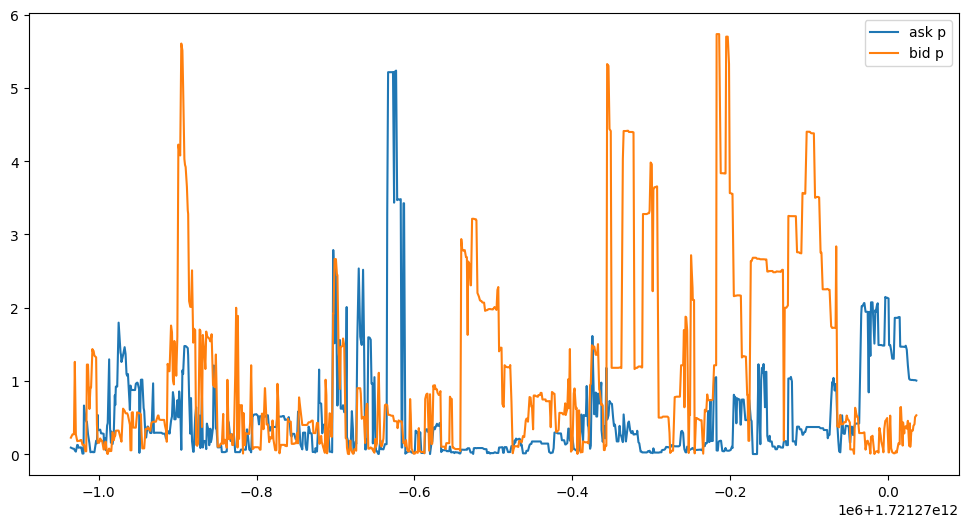

In [15]:
plt.figure(figsize=(12,6))
plt.plot(pressures[:,0], pressures[:,1], label="ask p")
plt.plot(pressures[:,0], pressures[:,2], label="bid p")
plt.legend()
plt.show()

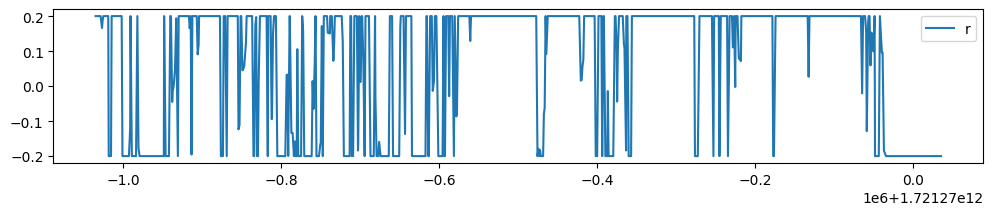

In [24]:
plt.figure(figsize=(12,2))
r = (pressures[:,1] - pressures[:,2]) / (pressures[:,1] + pressures[:,2])
plt.plot(pressures[:,0], np.clip(-r, -0.2, 0.2), label="r")
plt.legend()
plt.show()

r>0이 많이 유지되는 구간 = 상승 압력이 높은 구간 = 가격 상승을 기대할 수 있음

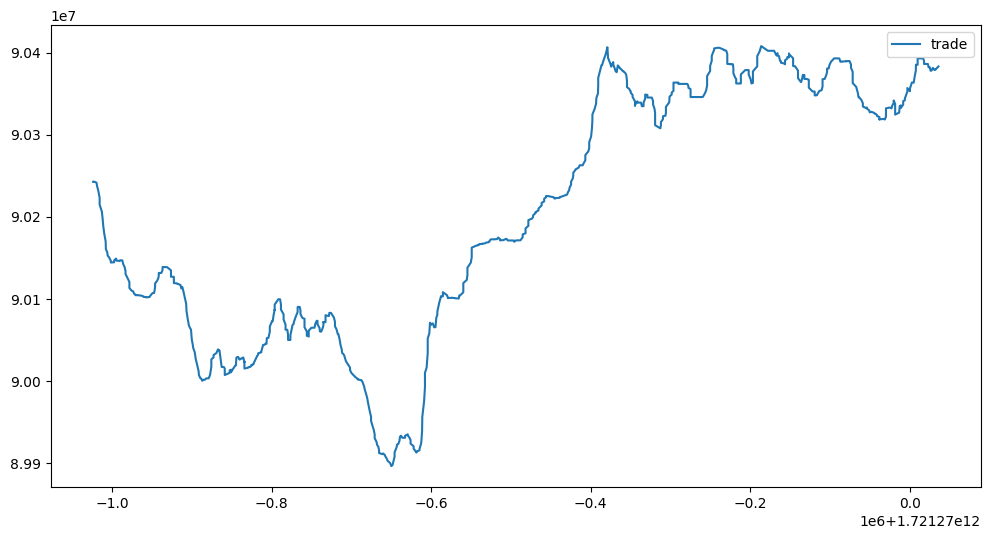

In [22]:
trps = smoothen(trade_prices, k=10)
plt.figure(figsize=(12,6))
plt.plot(trps[:,0], trps[:,1], label="trade")
plt.legend()
plt.show()

100%|█████████████████████████████████████████████████████████████████████████████████| 600/600 [12:00<00:00,  1.20s/it]


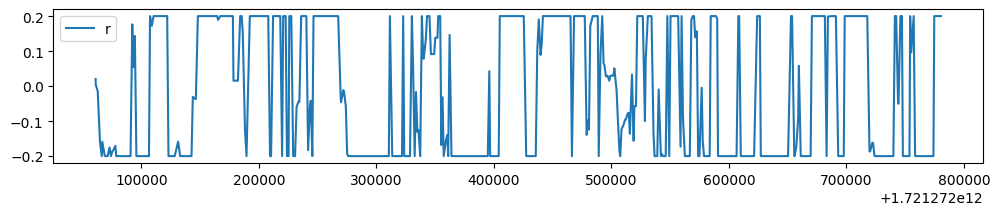

In [25]:
weighted_prices, trade_prices, total_weighted_prices, pressures = save_prices(count=60*10)
weighted_prices = np.array(weighted_prices)
trade_prices = np.array(trade_prices)
total_weighted_prices = np.array(total_weighted_prices)
pressures = np.array(pressures)

plt.figure(figsize=(12,2))
r = (pressures[:,1] - pressures[:,2]) / (pressures[:,1] + pressures[:,2])
plt.plot(pressures[:,0], np.clip(-r, -0.2, 0.2), label="r")
plt.legend()
plt.show()

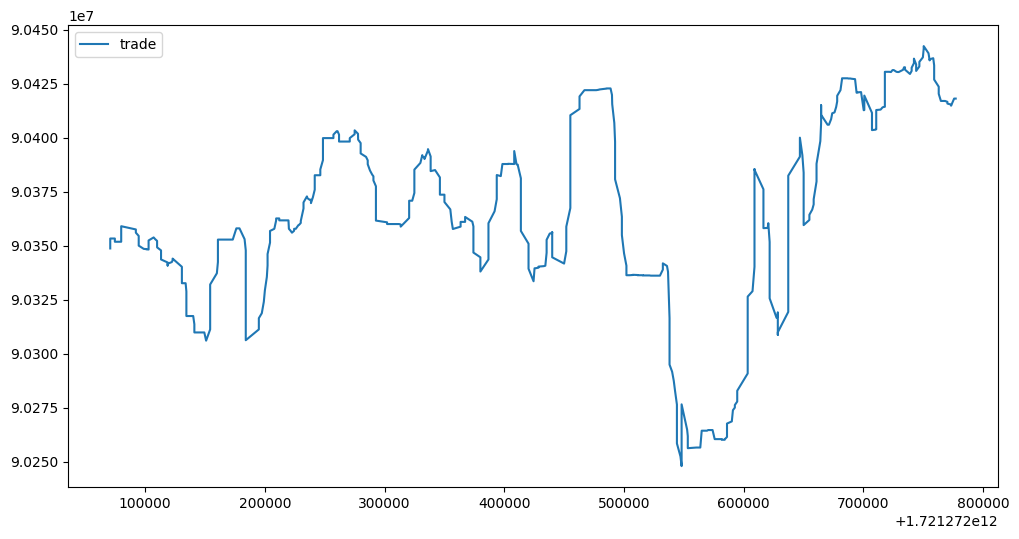

In [31]:
trps = smoothen(trade_prices, k=10)
plt.figure(figsize=(12,6))
plt.plot(trps[:,0], trps[:,1], label="trade")
plt.legend()
plt.show()